<a href="https://colab.research.google.com/github/fernandocillo/EG940/blob/main/Projeto_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto #3: Síntese de Sinais Musicais 

EG940 - Engenharia de Som II: Análise e Síntese de Sinais Musicais \\

Fernando Teodoro de Cillo - RA 197029 \\
Guilherme Lôbo Calazans Machado - RA 235997 \\
Nyahn Ekyê Fernandes Duarte - RA 204234 \\

# Introdução

O objetivo deste trabalho é aplicar ferramentas de síntese e processamento de áudio para sintetizar um som. \\
O som escolhido foi o riff principal da música *Smoke on The Water*, da banda inglesa Deep Purple. \\

Para realizar a síntese do sinal foi utilizado o modelo físico de Karplus-Strong para cordas vibrantes.

# Síntese de uma nota

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importando as bibliotecas e funções necessárias

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import librosa
import scipy.signal
from librosa import display

In [ ]:
# Definição da função "timbre", que modela o ADSR das notas

def timbre(x,n):
  for i in range(1,20): #Attack
    x[n]=0
    x[n+20*i]=0.005+x[n+(i-1)*20]
  for i in range(1,10): #Decay
    x[n+400+i*400]=0.9*x[n+(i-1)*400]
    return

# As etapas de Sustain e Release são dadas pelo atraso do modelo

## Teste do modelo

Nesta seção realizaremos o teste do modelo e os ajustes necessários para que a nota se pareça com a de um violão com cordas de aço.

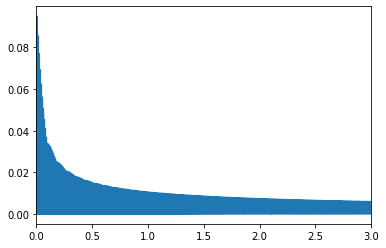

In [ ]:
f0 = 110 #Frequência fundamental da nota
fs = 44100 #Frequência de amostragem
T0 = 1/f0 #Período de amostragem
N0 = int(T0 * fs) #Número de nós

# vetor de atraso
# os valores foram obtidos por tentativa e erro
atraso = np.zeros(N0)
atraso[0] = 1
atraso[-1] = -0.9
atraso[-2] = -0.092
atraso[-3] = -0.007
atraso[-4] = -0.0009

# buffer do sinal de entrada
b = [1]

# vetor de impulsos (attack do sinal)
x = np.zeros(fs*3) #cria o vetor x
timbre(x,0) #estabelece um impulso no instante 0

# processo de filtragem com os parâmetros do modelo
teste_timbre = scipy.signal.lfilter(b, atraso, x)
t = np.arange(len(teste_timbre))/fs

# plot da figura
plt.figure()
plt.plot(t,teste_timbre)
plt.xlim([0, 3])
plt.show()

In [ ]:
# ouvindo a nota
Audio(data=teste_timbre, rate=fs)

Podemos notar que além da nota grave (110 Hz) desejada, há também a presença de um apito muito mais agudo. É necessário que ele seja eliminado para que possamos ouvir as notas que queremos em nossa música.

## Filtragem

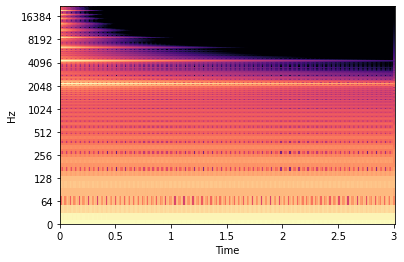

In [ ]:
# espectrograma da nota sintetizada

S = librosa.stft(teste_timbre, n_fft=2048, hop_length=512, win_length=1024)
S = np.abs(S)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', sr=fs)

Notamos raias em frequências graves (inclusive uma próxima a 110 Hz, apesar de não tão aparente), mas percebe-se também diversas raias agudas muito evidentes. Isso explica o som de apito ouvido.

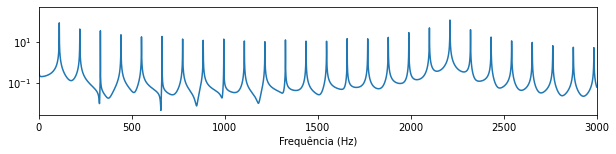

In [ ]:
# espectro da nota sintetizada
X_ = np.fft.fft(teste_timbre, len(teste_timbre))

f = np.linspace(0, fs, len(teste_timbre))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(X_))
plt.xlim([0,3000])
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

Percebemos que há diversas frequências altas muito evidentes, algumas inclusive mais intensas do que o som que desejávamos ouvir, o que corrobora com a percepção auditiva.

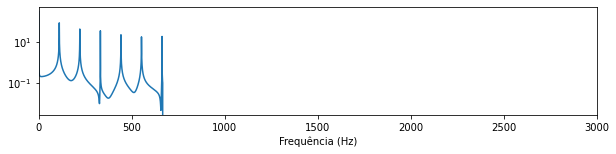

In [ ]:
# eliminando todas as frequências acima de 650 Hz
# filtro passa-baixas ideal
for i in range(0,len(X_)):
  if i>2000: X_[i]=0

f = np.linspace(0, fs, len(teste_timbre))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(X_))
plt.xlim([0,3000])
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

In [ ]:
x_filtrado = np.fft.ifft(X_, len(teste_timbre)) 

Audio(data=x_filtrado, rate=fs)

/usr/local/lib/python3.8/dist-packages/IPython/lib/display.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


Ouvindo o som filtrado percebe-se que foram eliminadas as frequências mais altas e o apito também não se escuta mais. Uma desvantagem é que surgem cliques no início e no fim do áudio, que podem ser corrigidos através do janelamento.

## Janelamento

In [ ]:
x_janela = np.hanning(132300)*x_filtrado

Audio(data=x_janela, rate=fs)

Após as etapas de filtragem e de janelamento, a nota começa a se assemelhar mais a um lá tocado no violão, que pode ser ouvido a seguir para comparação.

## Comparação

In [ ]:
# Nota lá de 110 Hz tocada num violão com cordas de aço

la_violao = '/content/4a-nota-violao-_LA_.wav'
la110, sr = librosa.load(la_violao, sr=fs, mono=True)
Audio(data=la110, rate=fs)

In [ ]:
# definição da função forma de onda,
# que plota a forma de onda do sinal
def forma_de_onda(x, sr):
  t = np.linspace(0, len(x)/sr, len(x))
  plt.figure()
  plt.plot(t,x)
  plt.ylim(bottom=0)
  plt.show()
  return

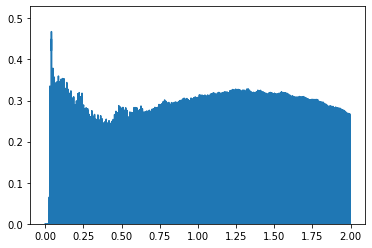

In [ ]:
compara, sr = librosa.load(la_violao, sr=fs, mono=True)
forma_de_onda(compara,sr)

É possível visualizar o envoltório do sinal, com um Attack muito rápido (praticamente instantâneo) e atingindo o maior pico de intensidade, Decay de cerca de 0.5s, Sustain de 0.5 até 1.5 segundos que eleva ligeiramente a intensidade e depois um Release a partir de 1.5s. \\

O envoltório do som sintetizado é similar o suficiente, então podemos prosseguir com a aplicação do nosso modelo.

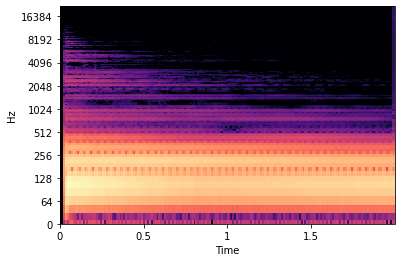

In [ ]:
# espectrograma da nota gravada 
S = librosa.stft(compara, n_fft=2048, hop_length=512, win_length=1024)
S = np.abs(S)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', sr=fs)

O espectrograma é similar ao da nota sintetizada, exceto pelos picos em notas mais altas, que foram eliminadas na filtragem).

# Síntese dos acordes

In [ ]:
dist=0.55*44100
dist=int(dist)

dist2=0.75*44100
dist2=int(dist2)

dist3=0.27*44100
dist3=int(dist3)

dist4=0.85*44100
dist4=int(dist4)

In [ ]:
nota0 = 0
nota1 = nota0 + dist
nota2 = nota1 + dist

nota3 = nota2 + dist2
nota4 = nota3 + dist
nota5 = nota4 + dist
nota6 = nota5 + dist3

nota7 = nota6 + dist4
nota8 = nota7 + dist
nota9 = nota8 + dist

nota10 = nota9 + dist2
nota11 = nota10 + dist

Os acordes utilizados no riff são Sol, Si Bemol, Dó e Dó Sustenido. Como a música é tocada com a técnica de *power chords*, cada acorde é composto por duas notas.

## Acordes

In [ ]:
# ACORDE DE SOL

# frequências fundamentais das notas que compõem o acorde
f0_1 = 196 # G
f0_2 = 146.83 # D

fs = 44100 #frequência de amostragem

#período de amostragem e número de nós da corda 1
T0_1 = 1/f0_1
N0_1 = int(T0_1 * fs)

#período de amostragem e número de nós da corda 2
T0_2 = 1/f0_2
N0_2 = int(T0_2 * fs)

#definição dos vetores de atraso, que neste caso são iguais
atraso1 = np.zeros(N0_1)
atraso1[0] = 1
atraso1[-1] = -0.9;
atraso1[-2] = -0.092;

atraso2 = np.zeros(N0_2)
atraso2[0] = 1
atraso2[-1] = -0.9;
atraso2[-2] = -0.092;

# buffer do sinal de entrada
# o mesmo impulso de ruído é utilizado para as duas notas
b = [1]

# vetor de impulsos (attack do sinal)
# o mesmo vetor é utilizado por que as notas são tocadas juntas
x = np.zeros(fs*10)

# definição dos instantes em que o acorde é tocado
timbre(x,nota0)
timbre(x,nota3)
timbre(x,nota7)
timbre(x,nota11)

# filtragem do sinal de cada uma das cordas
y1 = scipy.signal.lfilter(b, atraso1, x)
y2 = scipy.signal.lfilter(b, atraso2, x)
# o acorde é a soma temporal das duas notas
y_sol = y1+y2  

In [ ]:
# ACORDE DE SI BEMOL

# frequências fundamentais das notas que compõem o acorde
f0_1 = 174.61 # F
f0_2 = 233.08 # A#

fs = 44100 #frequência de amostragem

#período de amostragem e número de nós da corda 1
T0_1 = 1/f0_1
N0_1 = int(T0_1 * fs)

#período de amostragem e número de nós da corda 2
T0_2 = 1/f0_2
N0_2 = int(T0_2 * fs)

#definição dos vetores de atraso, que neste caso são iguais
atraso1 = np.zeros(N0_1)
atraso1[0] = 1
atraso1[-1] = -0.9;
atraso1[-2] = -0.092;

atraso2 = np.zeros(N0_2)
atraso2[0] = 1
atraso2[-1] = -0.9;
atraso2[-2] = -0.092;

# buffer do sinal de entrada
# o mesmo impulso de ruído é utilizado para as duas notas
b = [1]

# vetor de impulsos (attack do sinal)
# o mesmo vetor é utilizado por que as notas são tocadas juntas
x = np.zeros(fs*10)

# definição dos instantes em que o acorde é tocado
timbre(x,nota1)
timbre(x,nota4)
timbre(x,nota8)
timbre(x,nota10)

# filtragem do sinal de cada uma das cordas
y1 = scipy.signal.lfilter(b, atraso1, x)
y2 = scipy.signal.lfilter(b, atraso2, x)
# o acorde é a soma temporal das duas notas
y_si = y1+y2

In [ ]:
# ACORDE DE DÓ

# frequências fundamentais das notas que compõem o acorde
f0_1 = 261.62 # C
f0_2 = 196 # G

fs = 44100 #frequência de amostragem

#período de amostragem e número de nós da corda 1
T0_1 = 1/f0_1
N0_1 = int(T0_1 * fs)

#período de amostragem e número de nós da corda 2
T0_2 = 1/f0_2
N0_2 = int(T0_2 * fs)

#definição dos vetores de atraso, que neste caso são iguais
atraso1 = np.zeros(N0_1)
atraso1[0] = 1
atraso1[-1] = -0.9;
atraso1[-2] = -0.092;

atraso2 = np.zeros(N0_2)
atraso2[0] = 1
atraso2[-1] = -0.9;
atraso2[-2] = -0.092;

# buffer do sinal de entrada
# o mesmo impulso de ruído é utilizado para as duas notas
b = [1]

# vetor de impulsos (attack do sinal)
# o mesmo vetor é utilizado por que as notas são tocadas juntas
x = np.zeros(fs*10)

# definição dos instantes em que o acorde é tocado
timbre(x,nota2)
timbre(x,nota6)
timbre(x,nota9)

# filtragem do sinal de cada uma das cordas
y1 = scipy.signal.lfilter(b, atraso1, x)
y2 = scipy.signal.lfilter(b, atraso2, x)
# o acorde é a soma temporal das duas notas
y_do = y1+y2

In [ ]:
# ACORDE DE DÓ SUSTENIDO

# frequências fundamentais das notas que compõem o acorde
f0_1 = 277.18 # C#
f0_2 = 207.65 # G#

fs = 44100 #frequência de amostragem

#período de amostragem e número de nós da corda 1
T0_1 = 1/f0_1
N0_1 = int(T0_1 * fs)

#período de amostragem e número de nós da corda 2
T0_2 = 1/f0_2
N0_2 = int(T0_2 * fs)

#definição dos vetores de atraso, que neste caso são iguais
atraso1 = np.zeros(N0_1)
atraso1[0] = 1
atraso1[-1] = -0.9;
atraso1[-2] = -0.092;

atraso2 = np.zeros(N0_2)
atraso2[0] = 1
atraso2[-1] = -0.9;
atraso2[-2] = -0.092;

# buffer do sinal de entrada
# o mesmo impulso de ruído é utilizado para as duas notas
b = [1]

# vetor de impulsos (attack do sinal)
# o mesmo vetor é utilizado por que as notas são tocadas juntas
x = np.zeros(fs*10)

# definição do instante em que o acorde é tocado
timbre(x,nota5)

# filtragem do sinal de cada uma das cordas
y1 = scipy.signal.lfilter(b, atraso1, x)
y2 = scipy.signal.lfilter(b, atraso2, x)
# o acorde é a soma temporal das duas notas
y_do_sus = y1+y2

## Sinal

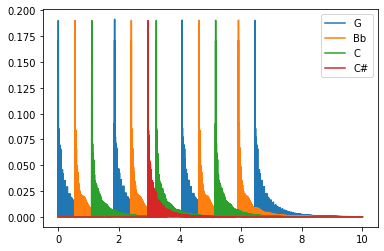

In [ ]:
# o sinal é composto pela soma temporal dos acordes
y = y_sol + y_si + y_do + y_do_sus

t = np.arange(len(y))/fs

plt.figure()
plt.plot(t, y_sol, label='G')
plt.plot(t, y_si, label='Bb')
plt.plot(t, y_do, label='C')
plt.plot(t, y_do_sus, label='C#')
plt.legend()
plt.show()

In [ ]:
Audio(data=y, rate=fs)

Nota-se que além das frequências fundamentais das notas de cada acorde há também o apito. Isso exige que façamos o mesmo procedimento de filtragem

## Filtragem

O primeiro passo é realizar a transformada de Fourier para identificar as frequências problemáticas.

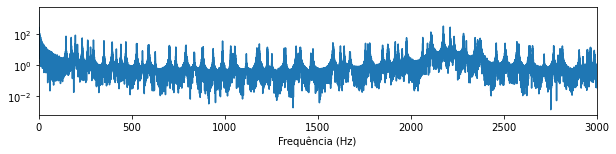

In [ ]:
Y_ = np.fft.fft(y, len(y))

f = np.linspace(0, fs, len(y))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(Y_))
plt.xlim([0,3000])
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

É possível indentificar componentes de frequência muito acima do range de frequências encontrado no riff original gravado, que é de um violão acústico (entre 80 Hz e 650 Hz aproximadamente). Para eliminá-los, vamos eliminar todas as frequências maiores que 650 Hz.

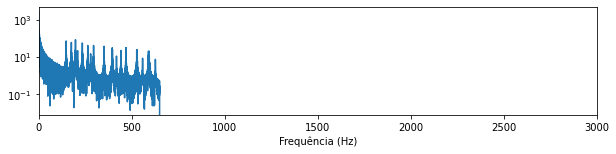

In [ ]:
# filtro passa-baixas ideal
for i in range(0,len(Y_)):
  if i>6500: Y_[i]=0

f = np.linspace(0, fs, len(y))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(Y_))
plt.xlim([0,3000])
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

## Comparação

In [ ]:
y_filtrado = np.fft.ifft(Y_, len(y)) 

Audio(data=y_filtrado, rate=fs)

/usr/local/lib/python3.8/dist-packages/IPython/lib/display.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [ ]:
smoke='/content/Smoke-on-the-water-acustico.wav'
Audio(data=smoke, rate=fs)

O som sintetizado já se assemelha ao riff desejado, é possível identificar os power chords, o som de apito foi eliminado e as notas são semelhantes às de um violão.

In [ ]:
musica, sr = librosa.load(smoke, sr=fs, mono=True)

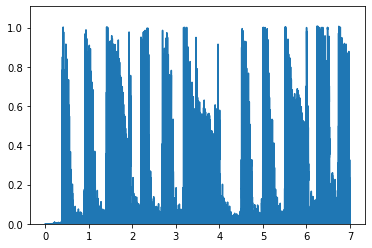

In [ ]:
forma_de_onda(musica,sr)

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


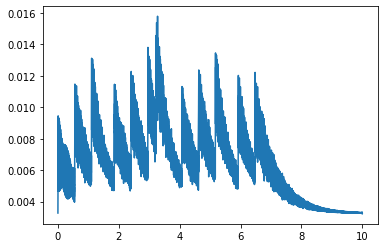

In [ ]:
t = np.arange(len(y_filtrado))/fs

plt.figure()
plt.plot(t, y_filtrado)
plt.show()

# Análise

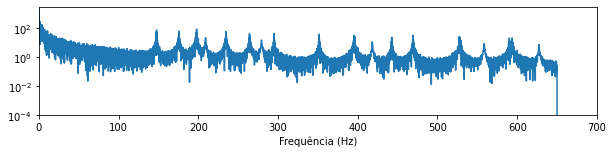

In [ ]:
# espectrograma do riff sintetizado

spec_smoke = np.fft.fft(y_filtrado, len(y_filtrado))

f = np.linspace(0, fs, len(y_filtrado))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(spec_smoke))
plt.xlim([0,700])
plt.ylim(bottom=0.0001)
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

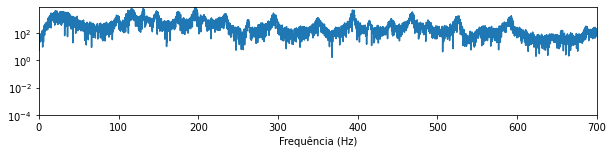

In [ ]:
# espectrograma do riff original

spec_smoke_original = np.fft.fft(musica, len(musica))

f = np.linspace(0, fs, len(musica))
plt.figure(figsize=(10,2))
plt.plot(f, np.abs(spec_smoke_original))
plt.xlim([0,700])
plt.ylim(bottom=0.0001)
plt.xlabel('Frequência (Hz)')
plt.semilogy()
plt.show()

Podemos notar que os picos de frequência do riff sintetizado são correspondentes aos principais picos do riff original, o que indica que a síntese ocorreu de forma satisfatória. 

Como passamos um filtro em 650 Hz, houve um corte das harmônicas mais agudas, presentes no riff original, fazendo com que o timbre do riff sintetizado não seja tão parecido com o de uma corda de violão, embora as frequências fundamentais dos power chords seja perceptível, bem como o tempo e o espaçamento entre as notas. 

# Conclusão

Após o resultado final e a comparação entre o sinal sintetizado e o sinal original, podemos concluir que o modelo utilizado foi adequado para a atividade inicialmente proposta. 

A síntese de acordes foi bem sucedida, uma vez que os acordes constituem de várias notas com frequências fundamentais diferentes, que, uma vez juntas, formam um som harmonioso. Utilzando o mesmo princípio, obteve-se um som polifônico que se assemelhou bastante aos power chords originais do riff. 

Além disso, o espaçamento entre os acordes foi bem próximo do espaçamento original da música. Este foi implementado empiricamente, comparando o resultado do áudio sintetizado com o original, e assim, otimizando-o até que chegasse em um resultado qualitativo desejado.

Por fim, o espectrograma corrobora com toda a análise supracitada, concluindo, então, que de forma quantitativa, os resultados obtidos também foram satisfatórios.  